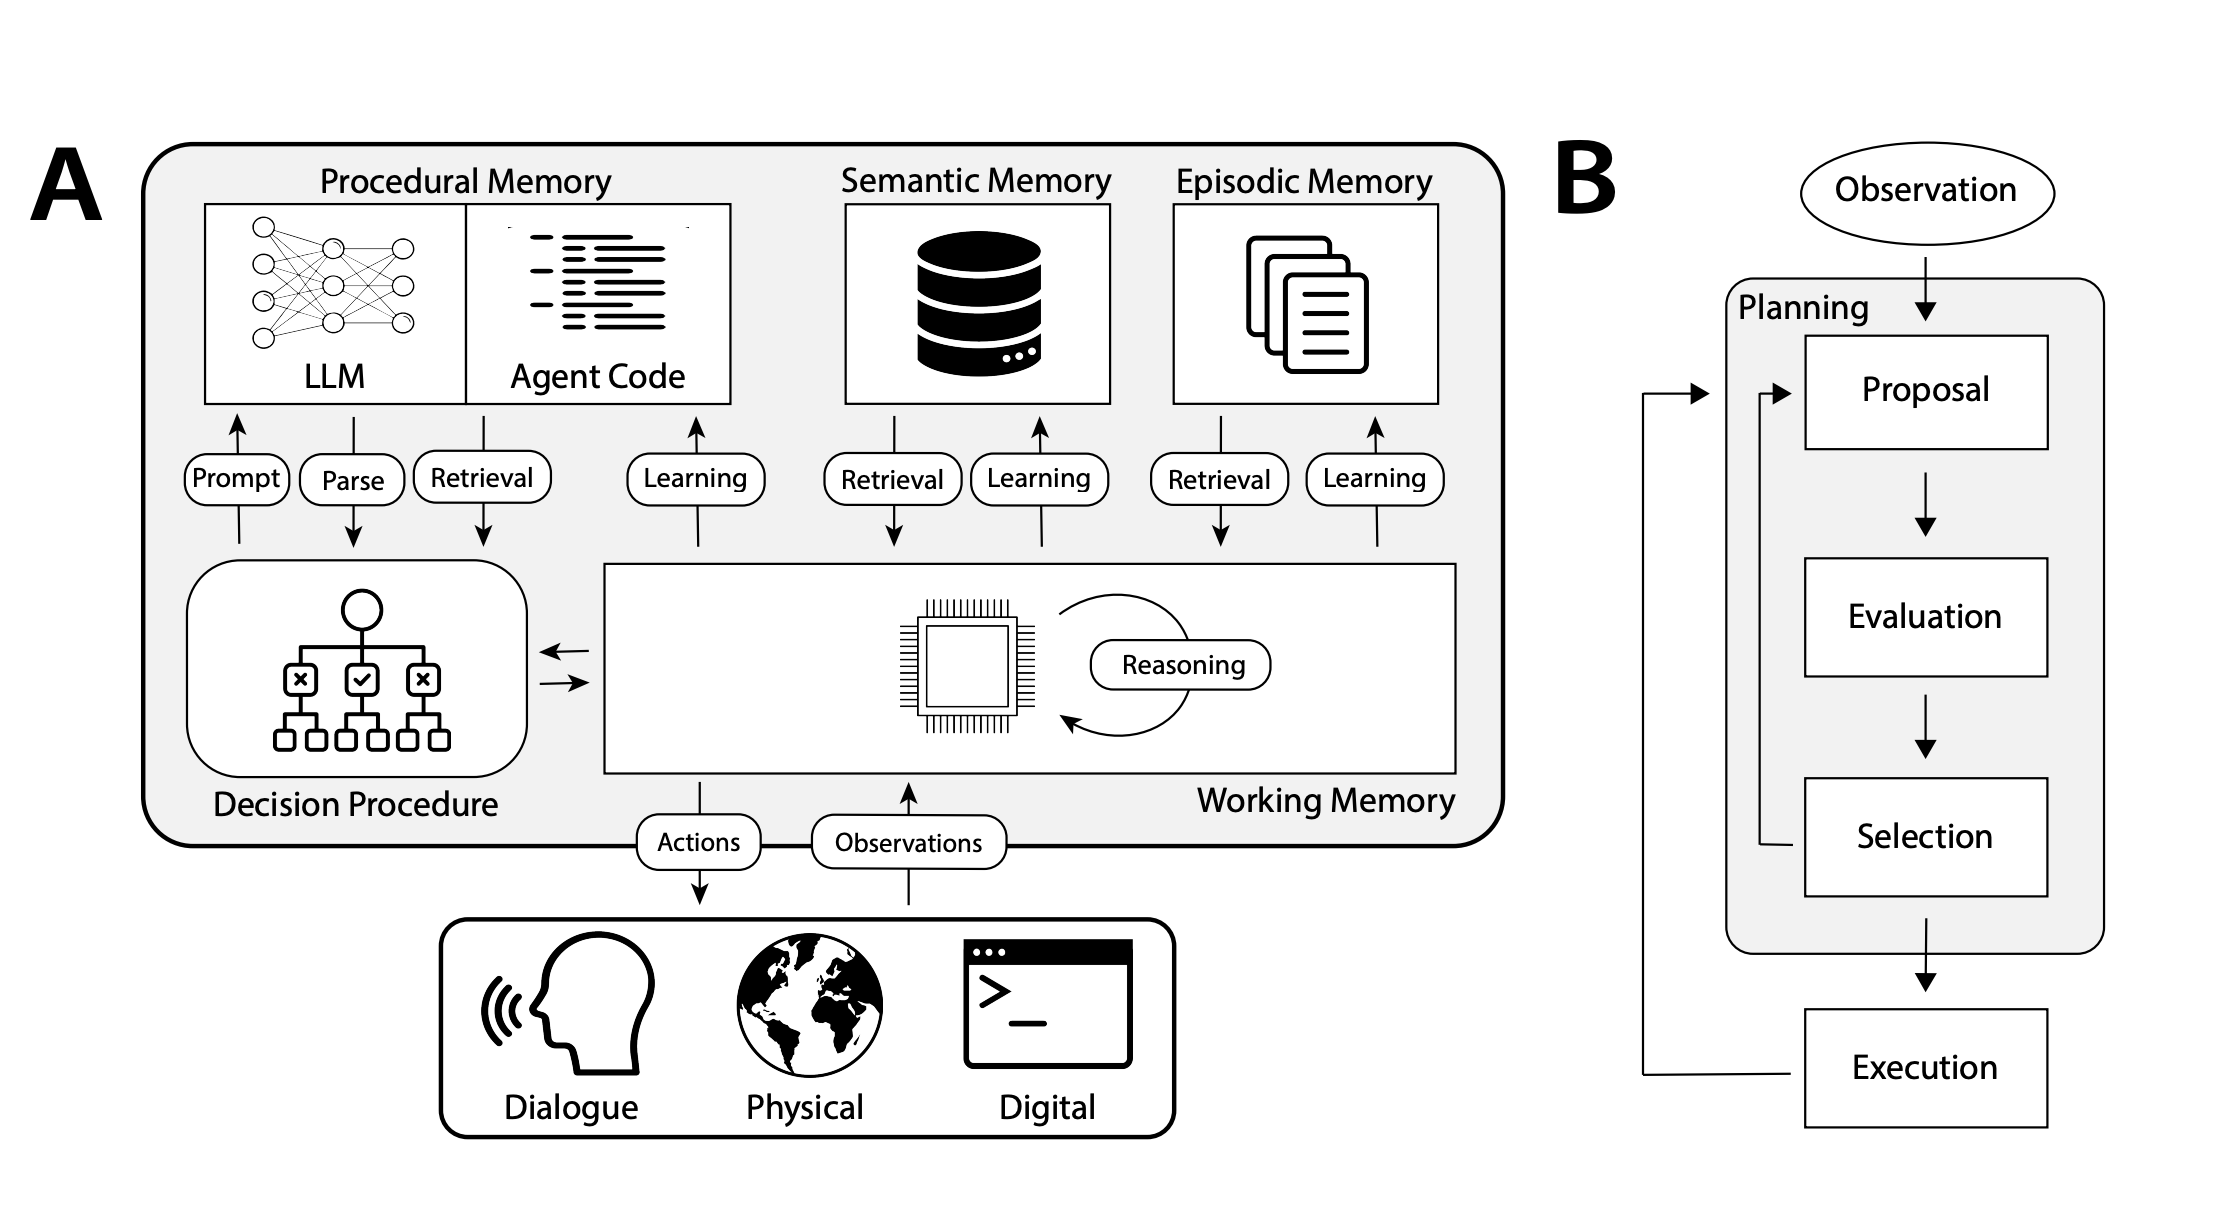

In [13]:
!pip install  weaviate-client -q
!pip install google-genai -q

/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/pty.py:95: DeprecationWarning: This process (pid=35246) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()



[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


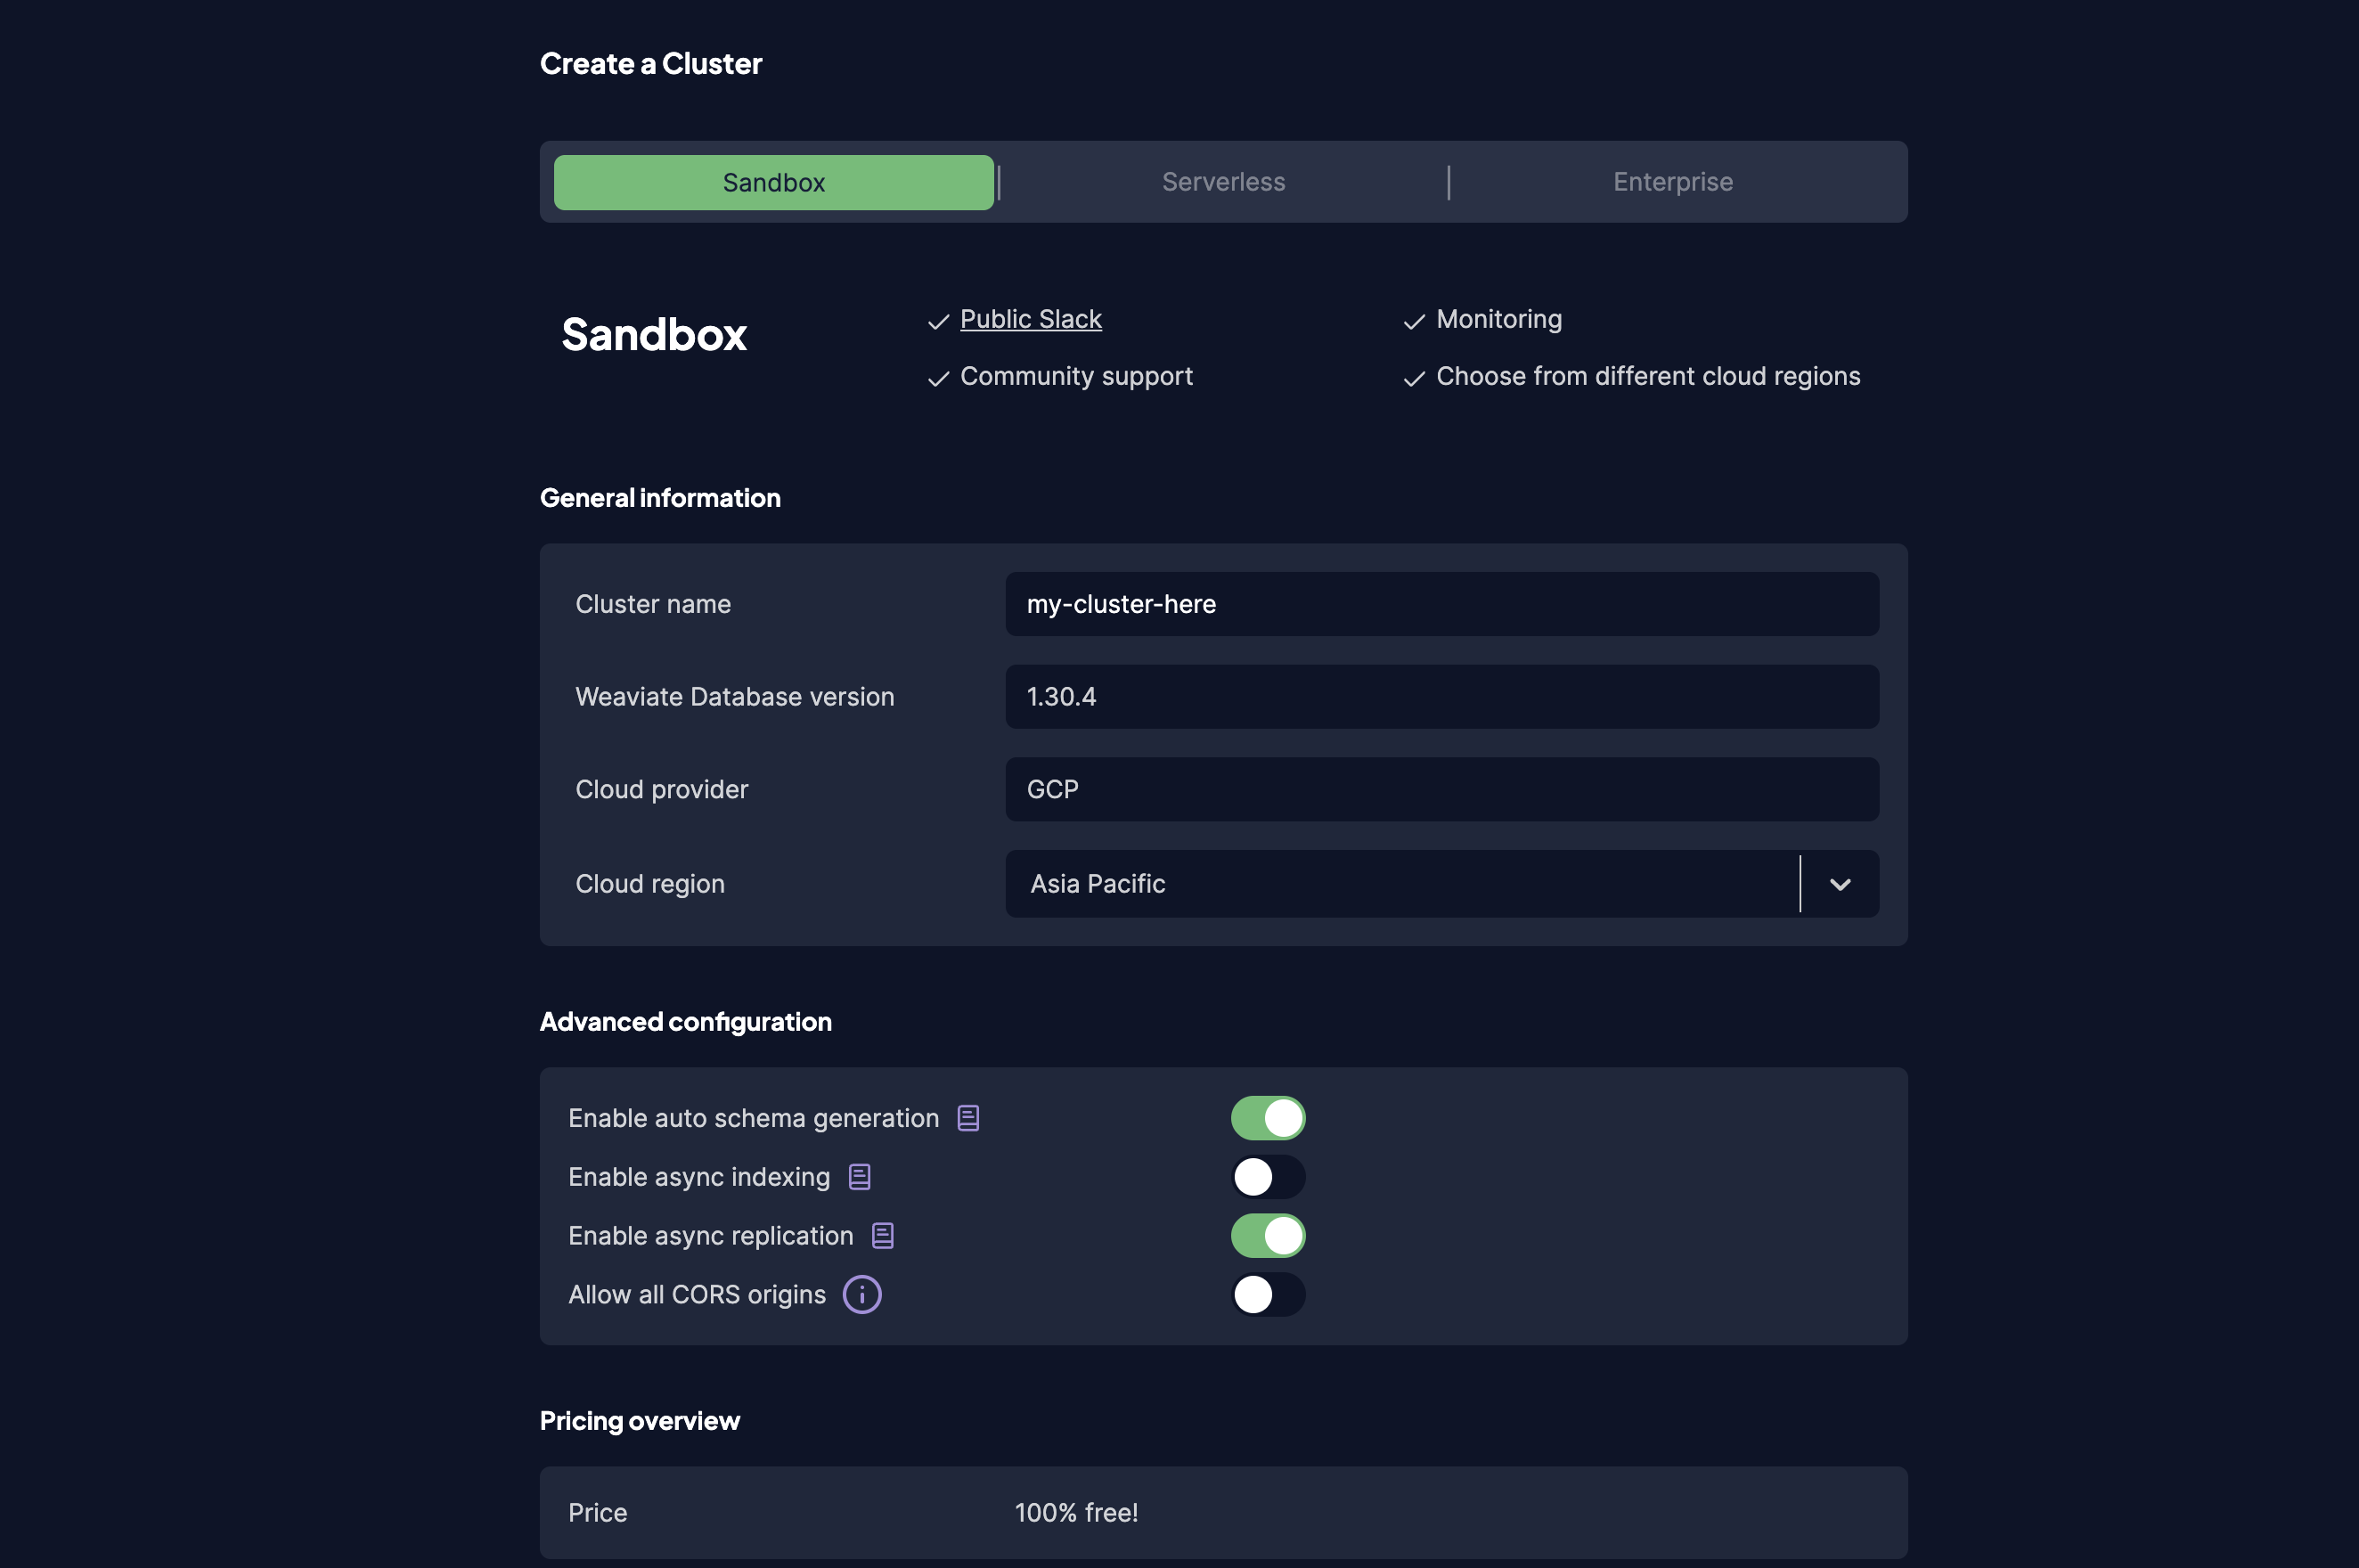

In [14]:
import weaviate
import os
from weaviate.auth import Auth
import setup_env


weaviate_url = os.environ.get("WEAVIATE_URL")
weaviate_api_key = os.environ.get("WEAVIATE_API_KEY")

vdb_client = weaviate.connect_to_weaviate_cloud(
    cluster_url=weaviate_url,
    auth_credentials=Auth.api_key(weaviate_api_key),
)

/Users/imdigitalashish/Projects/RealProj/Long-Term-Memory-AI/venv/lib/python3.13/site-packages/weaviate/warnings.py:314: ResourceWarning: Con004: The connection to Weaviate was not closed properly. This can lead to memory leaks.
            Please make sure to close the connection using `client.close()`.
  warnings.warn(
/var/folders/rr/7_mntwx97fs4bqhyrsw6dyww0000gn/T/ipykernel_35246/1519215650.py:10: ResourceWarning: unclosed <ssl.SSLSocket fd=73, family=2, type=1, proto=0, laddr=('192.168.29.51', 64555), raddr=('34.160.174.119', 443)>
  vdb_client = weaviate.connect_to_weaviate_cloud(


In [15]:
import base64
import os
from google import genai
from google.genai import types

In [38]:
import base64
import os
from google import genai
from google.genai import types
client = genai.Client(
    api_key=os.environ.get("GEMIMI_API_KEY"),
)

contents = [
    types.Content(
            role="user",
            parts=[
                types.Part.from_text(text="""hey how are you"""),
            ],
        ),
]

def generate():


    model = "gemini-2.5-flash-preview-05-20"
   
    generate_content_config = types.GenerateContentConfig(
        response_mime_type="text/plain",
    )

    response_text = ""
    for chunk in client.models.generate_content_stream(
        model=model,
        contents=contents,
        config=generate_content_config,
    ):
        response_text += chunk.text
        print(chunk.text, end="")
    
    # Add model response to contents
    contents.append(
        types.Content(
            role="model",
            parts=[
                types.Part.from_text(text=response_text),
            ],
        )
    )

def chat(message):
    # Add user message to contents
    contents.append(
        types.Content(
            role="user", 
            parts=[
                types.Part.from_text(text=message),
            ],
        )
    )
    generate()

if __name__ == "__main__":
    generate()
    while True:
        user_input = input("\nYou: ")
        if user_input.lower() in ['quit', 'exit']:
            break
        print("User: ", user_input)
        print("Assistant: ", end="")

        print()
        chat(user_input)


I'm doing great, thank you for asking!

How are you doing today?User:  Can you give some food to try out?
Assistant: 
Okay, I'd love to help you find some new delicious things to try! Since you didn't specify any preferences (like cuisine type, dietary needs, or spicy/mild), I'll give you a diverse list of popular and interesting dishes from around the world.

Here are some foods to try out, spanning different flavors and experiences:

**Comfort & Hearty:**

1.  **Lasagna (Italian):** Layers of pasta, rich meat sauce (or a vegetable alternative), creamy béchamel, and melted cheese. It's a classic for a reason – incredibly satisfying.
2.  **Ramen (Japanese):** Much more than instant noodles! A complex, deep broth (tonkotsu, shoyu, miso), springy noodles, tender pork (chashu), a soft-boiled egg, nori, and other toppings. Each bowl is an art form.
3.  **Shepherd's Pie (British/Irish):** A savory mince (ground meat) and vegetable filling, topped with a thick layer of creamy mashed potato, 

In [39]:
contents

[Content(parts=[Part(video_metadata=None, thought=None, inline_data=None, code_execution_result=None, executable_code=None, file_data=None, function_call=None, function_response=None, text='hey how are you')], role='user'),
 Content(parts=[Part(video_metadata=None, thought=None, inline_data=None, code_execution_result=None, executable_code=None, file_data=None, function_call=None, function_response=None, text="I'm doing great, thank you for asking!\n\nHow are you doing today?")], role='model'),
 Content(parts=[Part(video_metadata=None, thought=None, inline_data=None, code_execution_result=None, executable_code=None, file_data=None, function_call=None, function_response=None, text='Can you give some food to try out?')], role='user'),
 Content(parts=[Part(video_metadata=None, thought=None, inline_data=None, code_execution_result=None, executable_code=None, file_data=None, function_call=None, function_response=None, text="Okay, I'd love to help you find some new delicious things to try! S

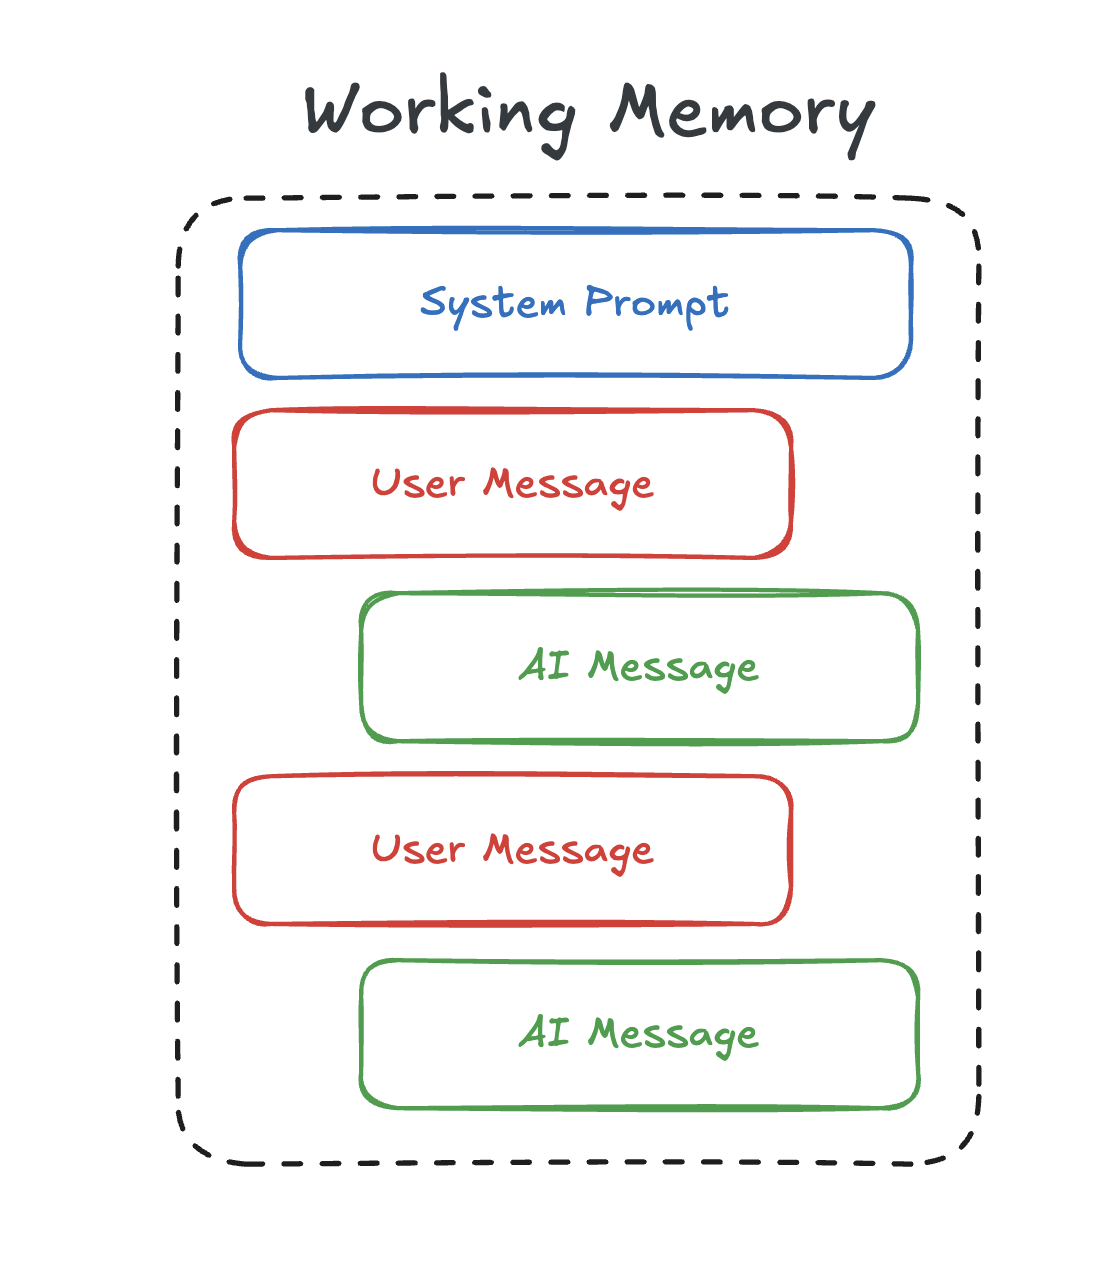

# Episodic Memory

In [40]:
get_conversation = ""
for message in contents:
    get_conversation += message.parts[0].text + "\n"
    

relection_prompt = f"""
You are analyzing conversations about research papers to create memories that will help guide future interactions. Your task is to extract key elements that would be most helpful when encountering similar academic discussions in the future.

Review the conversation and create a memory reflection following these rules:

1. For any field where you don't have enough information or the field isn't relevant, use "N/A"
2. Be extremely concise - each string should be one clear, actionable sentence
3. Focus only on information that would be useful for handling similar future conversations
4. Context_tags should be specific enough to match similar situations but general enough to be reusable

Output valid JSON in exactly this format:
{{
    "context_tags": [              // 2-4 keywords that would help identify similar future conversations
        string,                    // Use field-specific terms like "deep_learning", "methodology_question", "results_interpretation"
        ...
    ],
    "conversation_summary": string, // One sentence describing what the conversation accomplished
    "what_worked": string,         // Most effective approach or strategy used in this conversation
    "what_to_avoid": string        // Most important pitfall or ineffective approach to avoid
}}

Examples:
- Good context_tags: ["transformer_architecture", "attention_mechanism", "methodology_comparison"]
- Bad context_tags: ["machine_learning", "paper_discussion", "questions"]

- Good conversation_summary: "Explained how the attention mechanism in the BERT paper differs from traditional transformer architectures"
- Bad conversation_summary: "Discussed a machine learning paper"

- Good what_worked: "Using analogies from matrix multiplication to explain attention score calculations"
- Bad what_worked: "Explained the technical concepts well"

- Good what_to_avoid: "Diving into mathematical formulas before establishing user's familiarity with linear algebra fundamentals"
- Bad what_to_avoid: "Used complicated language"

Additional examples for different research scenarios:

Context tags examples:
- ["experimental_design", "control_groups", "methodology_critique"]
- ["statistical_significance", "p_value_interpretation", "sample_size"]
- ["research_limitations", "future_work", "methodology_gaps"]

Conversation summary examples:
- "Clarified why the paper's cross-validation approach was more robust than traditional hold-out methods"
- "Helped identify potential confounding variables in the study's experimental design"

What worked examples:
- "Breaking down complex statistical concepts using visual analogies and real-world examples"
- "Connecting the paper's methodology to similar approaches in related seminal papers"

What to avoid examples:
- "Assuming familiarity with domain-specific jargon without first checking understanding"
- "Over-focusing on mathematical proofs when the user needed intuitive understanding"

Do not include any text outside the JSON object in your response.

Here is the prior conversation:

{get_conversation}
"""

In [41]:
relection_prompt

'\nYou are analyzing conversations about research papers to create memories that will help guide future interactions. Your task is to extract key elements that would be most helpful when encountering similar academic discussions in the future.\n\nReview the conversation and create a memory reflection following these rules:\n\n1. For any field where you don\'t have enough information or the field isn\'t relevant, use "N/A"\n2. Be extremely concise - each string should be one clear, actionable sentence\n3. Focus only on information that would be useful for handling similar future conversations\n4. Context_tags should be specific enough to match similar situations but general enough to be reusable\n\nOutput valid JSON in exactly this format:\n{\n    "context_tags": [              // 2-4 keywords that would help identify similar future conversations\n        string,                    // Use field-specific terms like "deep_learning", "methodology_question", "results_interpretation"\n      

In [62]:
import json
episodic_generate_content_config = types.GenerateContentConfig(
    response_mime_type="application/json"
)

data = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=[
        types.Content(
            role="user",
            parts=[
            types.Part.from_text(text=relection_prompt)
            ]
        )
    ],
    config=episodic_generate_content_config
)

reflection = json.loads(data.text)
reflection

{'context_tags': ['food_recommendation',
  'vegetarian_options',
  'preference_elicitation'],
 'conversation_summary': 'Provided a list of diverse food recommendations, then adjusted the list to accommodate vegetarian dietary restrictions.',
 'what_worked': 'Asking clarifying questions about dietary restrictions and flavor preferences to refine recommendations.',
 'what_to_avoid': 'Making assumptions about dietary restrictions; explicitly confirming preferences is important.'}

In [65]:
from weaviate.classes.config import Property, DataType, Configure, Tokenization

vdb_client.collections.create(
    name="episodic_memory",
    description="Collection containing historical chat interactions and takeaways.",
    vectorizer_config=Configure.Vectorizer.text2vec_weaviate(), # Configure the Weaviate Embeddings integration

    properties=[
        Property(name="conversation", data_type=DataType.TEXT),
        Property(name="context_tags", data_type=DataType.TEXT_ARRAY),
        Property(name="conversation_summary", data_type=DataType.TEXT),
        Property(name="what_worked", data_type=DataType.TEXT),
        Property(name="what_to_avoid", data_type=DataType.TEXT),
        
    ]
)

In [60]:
def format_conversation(messages):
    
    # Create an empty list placeholder
    conversation = []
    
    # Start from index 1 to skip the first system message
    for message in messages[1:]:
        
        conversation.append(f"{ message.role.upper() }: { message.parts[0].text }")
    
    # Join with newlines
    return "\n".join(conversation)

conversation = format_conversation(contents)

print(conversation)

MODEL: I'm doing great, thank you for asking!

How are you doing today?
USER: Can you give some food to try out?
MODEL: Okay, I'd love to help you find some new delicious things to try! Since you didn't specify any preferences (like cuisine type, dietary needs, or spicy/mild), I'll give you a diverse list of popular and interesting dishes from around the world.

Here are some foods to try out, spanning different flavors and experiences:

**Comfort & Hearty:**

1.  **Lasagna (Italian):** Layers of pasta, rich meat sauce (or a vegetable alternative), creamy béchamel, and melted cheese. It's a classic for a reason – incredibly satisfying.
2.  **Ramen (Japanese):** Much more than instant noodles! A complex, deep broth (tonkotsu, shoyu, miso), springy noodles, tender pork (chashu), a soft-boiled egg, nori, and other toppings. Each bowl is an art form.
3.  **Shepherd's Pie (British/Irish):** A savory mince (ground meat) and vegetable filling, topped with a thick layer of creamy mashed potato

In [66]:
def add_episodic_memory(messages, vdb_client):

    # Format Messages
    conversation = format_conversation(messages)


    # Load Database Collection
    episodic_memory = vdb_client.collections.get("episodic_memory")

    # Insert Entry Into Collection
    episodic_memory.data.insert({
        "conversation": conversation,
        "context_tags": reflection['context_tags'],
        "conversation_summary": reflection['conversation_summary'],
        "what_worked": reflection['what_worked'],
        "what_to_avoid": reflection['what_to_avoid'],
    })

add_episodic_memory(contents, vdb_client)

In [67]:
def episodic_recall(query, vdb_client):
    
    # Load Database Collection
    episodic_memory = vdb_client.collections.get("episodic_memory")

    # Hybrid Semantic/BM25 Retrieval
    memory = episodic_memory.query.hybrid(
        query=query,
        alpha=0.5,
        limit=1,
    )
    
    return memory

query = "Food Preferences"

memory = episodic_recall(query, vdb_client)

memory.objects[0].properties

{'what_worked': 'Asking clarifying questions about dietary restrictions and flavor preferences to refine recommendations.',
 'conversation_summary': 'Provided a list of diverse food recommendations, then adjusted the list to accommodate vegetarian dietary restrictions.',
 'context_tags': ['food_recommendation',
  'vegetarian_options',
  'preference_elicitation'],
 'conversation': 'MODEL: I\'m doing great, thank you for asking!\n\nHow are you doing today?\nUSER: Can you give some food to try out?\nMODEL: Okay, I\'d love to help you find some new delicious things to try! Since you didn\'t specify any preferences (like cuisine type, dietary needs, or spicy/mild), I\'ll give you a diverse list of popular and interesting dishes from around the world.\n\nHere are some foods to try out, spanning different flavors and experiences:\n\n**Comfort & Hearty:**\n\n1.  **Lasagna (Italian):** Layers of pasta, rich meat sauce (or a vegetable alternative), creamy béchamel, and melted cheese. It\'s a cla

In [68]:
# Simple storage for accumulated memories
conversations = []
what_worked = set()
what_to_avoid = set()

def episodic_system_prompt(query, vdb_client):
    # Get new memory
    memory = episodic_recall(query, vdb_client)

    current_conversation = memory.objects[0].properties['conversation']
    # Update memory stores, excluding current conversation from history
    if current_conversation not in contents:
        contents.append(current_conversation)
    # conversations.append(memory.objects[0].properties['conversation'])
    what_worked.update(memory.objects[0].properties['what_worked'].split('. '))
    what_to_avoid.update(memory.objects[0].properties['what_to_avoid'].split('. '))

    # Get previous conversations excluding the current one
    previous_convos = [conv for conv in conversations[-4:] if conv != current_conversation][-3:]
    
    # Create prompt with accumulated history
    episodic_prompt = f"""You are a helpful AI Assistant. Answer the user's questions to the best of your ability.
    You recall similar conversations with the user, here are the details:
    
    Current Conversation Match: {memory.objects[0].properties['conversation']}
    Previous Conversations: {' | '.join(previous_convos)}
    What has worked well: {' '.join(what_worked)}
    What to avoid: {' '.join(what_to_avoid)}
    
    Use these memories as context for your response to the user."""
    
    return episodic_prompt

In [70]:
episodic_system_prompt("Food preference", vdb_client)

'You are a helpful AI Assistant. Answer the user\'s questions to the best of your ability.\n    You recall similar conversations with the user, here are the details:\n\n    Current Conversation Match: MODEL: I\'m doing great, thank you for asking!\n\nHow are you doing today?\nUSER: Can you give some food to try out?\nMODEL: Okay, I\'d love to help you find some new delicious things to try! Since you didn\'t specify any preferences (like cuisine type, dietary needs, or spicy/mild), I\'ll give you a diverse list of popular and interesting dishes from around the world.\n\nHere are some foods to try out, spanning different flavors and experiences:\n\n**Comfort & Hearty:**\n\n1.  **Lasagna (Italian):** Layers of pasta, rich meat sauce (or a vegetable alternative), creamy béchamel, and melted cheese. It\'s a classic for a reason – incredibly satisfying.\n2.  **Ramen (Japanese):** Much more than instant noodles! A complex, deep broth (tonkotsu, shoyu, miso), springy noodles, tender pork (chas

In [71]:
import base64
import os
from google import genai
from google.genai import types
client = genai.Client(
    api_key=os.environ.get("GEMIMI_API_KEY"),
)

contents = [

    types.Content(
            role="user",
            parts=[
                types.Part.from_text(text="""hey how are you"""),
            ],
        ),
]

def generate():


    model = "gemini-2.5-flash-preview-05-20"
   
    generate_content_config = types.GenerateContentConfig(
        response_mime_type="text/plain",
        system_instruction=episodic_system_prompt("Food preference", vdb_client)
    )

    response_text = ""
    for chunk in client.models.generate_content_stream(
        model=model,
        contents=contents,
        config=generate_content_config,
    ):
        response_text += chunk.text
        print(chunk.text, end="")
    
    # Add model response to contents
    contents.append(
        types.Content(
            role="model",
            parts=[
                types.Part.from_text(text=response_text),
            ],
        )
    )

def chat(message):
    # Add user message to contents
    contents.append(
        types.Content(
            role="user", 
            parts=[
                types.Part.from_text(text=message),
            ],
        )
    )
    generate()

if __name__ == "__main__":
    generate()
    while True:
        user_input = input("\nYou: ")
        if user_input.lower() in ['quit', 'exit']:
            break
        print("User: ", user_input)
        print("Assistant: ", end="")

        print()
        chat(user_input)


The very first question you asked in this conversation was:

"**hey how are you**"User:  give me some food ideas to eat
Assistant: 
Okay, I can definitely give you more food ideas! Thanks again for clarifying that you're vegetarian – that's super helpful.

Since you've already seen some of my previous suggestions, here are some **new and diverse vegetarian dishes** for you to explore:

**Hearty & Satisfying:**

1.  **Mushroom Risotto (Italian):** A creamy, comforting rice dish cooked slowly with vegetable broth, sautéed mushrooms, onion, garlic, and Parmesan cheese (or a vegetarian alternative). It's rich, savory, and incredibly satisfying.
2.  **Vegetable Thai Green Curry (Thai):** A vibrant and aromatic curry made with coconut milk, green curry paste, and a medley of vegetables like bamboo shoots, bell peppers, eggplant, and often tofu. It's spicy, sweet, and incredibly flavorful, best served with jasmine rice.
3.  **Shakshuka (Middle Eastern/North African):** A flavorful and vibrant